# ARIMA Based Time Series Predictions

- The data for this analysis was obtained from Redfin
- Please note, no exogenous variables were considered in this analysis

This time series based ARIMA approach attempts to predict the median housing price for San Diego over the next two years utilizing historical data. This approach was completed in the following steps:

1. The data was transforming and filtered
2. Patterns in the time series were discovered and decomposed into a trend, seasonality, and residual
3. Three predictions of the decomposed time series were combined to make a monthly prediction

### Import Required Packages

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

from tqdm import tqdm
import time

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose      
from pmdarima import auto_arima
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

### Load Data

In [3]:
df = pd.read_csv("redfin_data.tsv", delimiter = '\t' )

### Establish State and County Columns

In [4]:
# County
df['county'] = df["region_name"].apply(lambda x: pd.Series(str(x).split(",")[0]))  

# States
states = []
errors = []  

for i in tqdm (range(len(df)), desc="Loading..."):
    try:
        state = str(df.loc[i]["region_name"]).split(',')[1].split(' ')[1]
        states.append(state)
    
    except:
        errors.append(i)
        
df_updated = df.drop(errors).reset_index()

df_updated['state'] = states

Loading...: 100%|██████████████████████████████████████████████████████████| 3521748/3521748 [06:16<00:00, 9347.93it/s]


### Filter the Data to the Desired Market and Features

In [9]:
# Filter for the desired state
df_ca = df_updated[df_updated['state'] == 'CA']

# Filter for the desired periodic duration of data
df_12 = df_ca[df_ca['duration'] == '12 weeks']
df_12 = df_12[df_12['county'] == 'San Diego County']

# Add a "date" datetime column
df_12['date']=pd.to_datetime(df_12['period_end'])

# Filter the columns or features relevent for the analysis
df_final = df_12[['date', 'median_sale_price']]

# Set "date" to be the index
df_final.set_index('date',inplace=True)

# Sort the index and set the desired frequency
df_final.sort_index(inplace=True)
df_final.index.freq = 'W'

# Review the final dataframe
df_final.head(5)

,median_sale_price
date,
2017-03-26,508833.3
2017-04-02,512583.3
2017-04-09,515083.3
2017-04-16,514666.6
2017-04-23,516833.3


### Discover the Various Time Series Componants

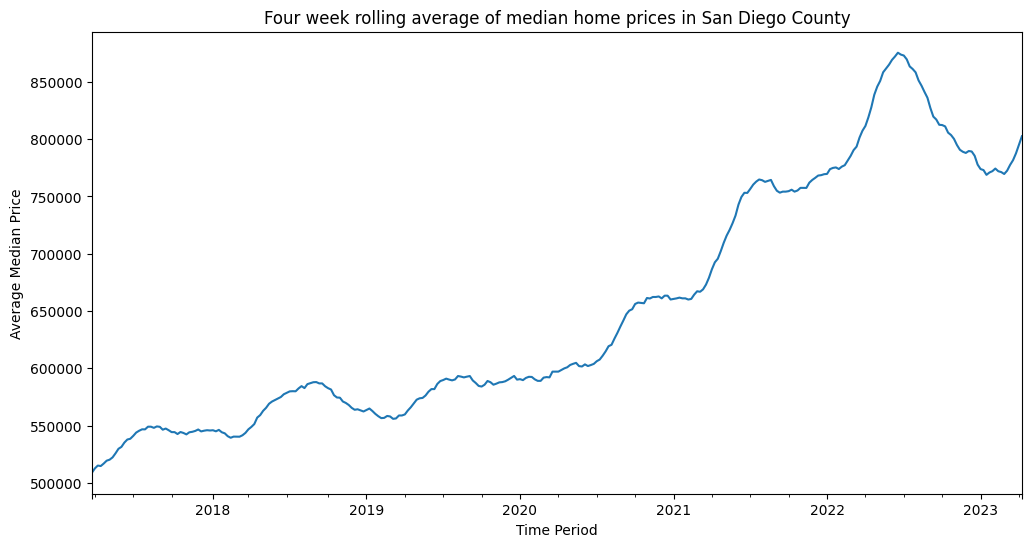

In [11]:
# Visualize the Median Sale Price Across Time
title = 'Four week rolling average of median home prices in San Diego County'
ylabel='Average Median Price'
xlabel = 'Time Period'

ax = df_final['median_sale_price'].plot(figsize=(12,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

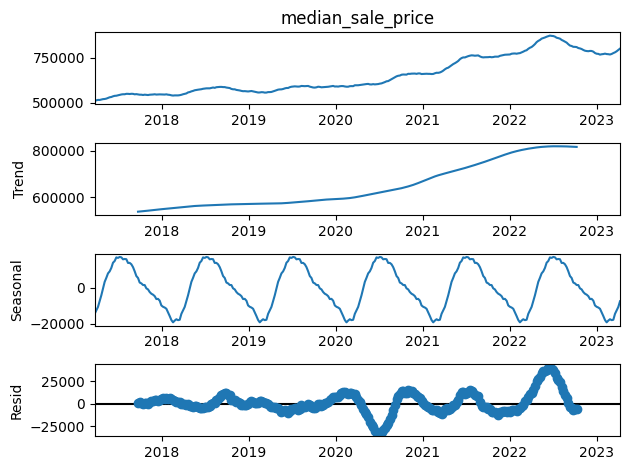

In [15]:
# Decompose the time series into trend, seasonal, and residual components
decomposition = seasonal_decompose(df_final['median_sale_price'], model='additive')

decomposition.plot();

In [20]:
# Extract the trend, seasonal, and residual components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [21]:
# Create a dataframe with the three components and resample with a month start
df_ts = df_final
df_ts['trend'] = trend
df_ts['seasonality'] = seasonal
df_ts['residuals'] = residual

df_ts = df_ts.resample('MS').mean()
df_ts = df_ts.dropna()

# Visualize Resulting dataframe
df_ts.head()

,median_sale_price,trend,seasonality,residuals
date,,,,
2017-09-01,547156.900,539310.051923,8254.428537,1096.062689
2017-10-01,543813.140,541348.718077,1678.781363,785.640560
2017-11-01,544068.175,544838.962019,-2556.393762,1785.606743
2017-12-01,545724.980,548346.084615,-6786.639772,4165.535157
2018-01-01,545317.650,551522.194471,-11704.515205,5499.970733


### Predictions

In [23]:
#Time periods to predict - 24 months
fcast_period = 24

# Create and empty prediction dataframe to hold values
fcast_df = pd.DataFrame()

### Trend

<AxesSubplot: xlabel='date'>

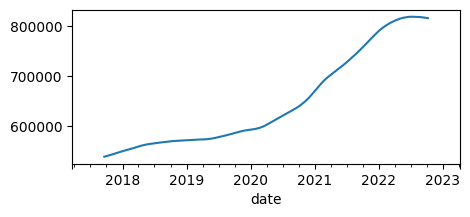

In [26]:
trend.plot(figsize=(5,2))

In [27]:
# Calculate the rolling average with the desired window
rolling_avg = df_ts['trend'].rolling(window=3).mean()

# Fit a linear regression model to the rolling average
X = pd.Series(range(len(rolling_avg)))[:-2]
y = rolling_avg.values[2:]
model = LinearRegression().fit(X.to_numpy().reshape(-1, 1), y)

# Predict the future values of the rolling average
future_X = pd.Series(range(len(rolling_avg), len(rolling_avg) + fcast_period))
future_y = model.predict(future_X.to_numpy().reshape(-1, 1))

# Add predicted values to the dataframe
fcast_df['pred_trend'] = future_y

### Seasonality

<AxesSubplot: xlabel='date'>

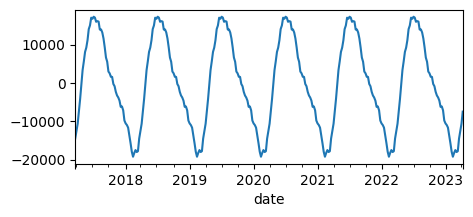

In [28]:
seasonal.plot(figsize=(5,2))

In [29]:
# Discover where the data left off relative to the seasonal trend
df_ts['seasonality'].tail(fcast_period).values

array([ -2967.17323348,  -7330.7269354 , -12508.66592579, -18237.2800604 ,
       -15708.62900271,  -5650.58534887,   7485.17265113,  15697.57344921,
        16600.40695883,  13729.68903575,   6100.33538831,    913.93422806,
        -3496.2569354 ,  -7330.7269354 , -12508.66592579, -18237.2800604 ,
       -15708.62900271,  -5650.58534887,   7485.17265113,  15697.57344921,
        16480.65957421,  13161.69378575,   6100.33538831,    913.93422806])

In [35]:
# In this case there appears to be a pattern of six positive months followed by six negative months
fcast_df['seasonal'] = df_ts['seasonality'].tail(fcast_period).values

# It is an assumption that the monthly effect will continue into the forcasted time period
fcast_df['seasonal'] = df_ts['seasonality'].tail(fcast_period).values

### Residuals

<AxesSubplot: xlabel='date'>

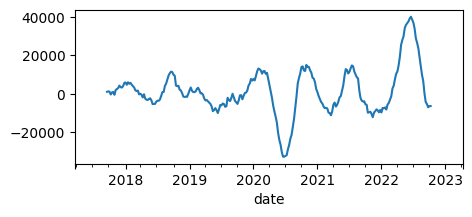

In [30]:
residual.plot(figsize=(5,2))

In [31]:
# Discover ARIMA Order
auto_arima(df_ts['residuals']).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   62
Model:               SARIMAX(2, 0, 2)   Log Likelihood                -591.879
Date:                Tue, 16 May 2023   AIC                           1193.758
Time:                        12:18:51   BIC                           1204.393
Sample:                    09-01-2017   HQIC                          1197.934
                         - 10-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1898      0.115     10.324      0.000       0.964       1.416
ar.L2         -0.6427      0.144     -4.449      0.000      -0.926      -0.360
ma.L1          0.6247      0.179      3.489      0.000       0.274       0.976
ma.L2          0.5932      0.148      4.021      0.000       0.304       0.882
sigma2      1.285e+07    1.7e-09   7.56e+15      0.000    1.28e+07    1.28e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 2.22
Prob(Q):                              0.91   Prob(JB):                         0.33
Heteroskedasticity (H):               3.11   Skew:                            -0.02
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.21e+31. Standard errors may be unstable.
"""

In [33]:
# Residuals appear to follow and ARIMA order of (2,0,2)
model = SARIMAX(df_ts['residuals'],order=(2,0,2))
results = model.fit()

# Forecast the residual values into the prediction interval
fcast_resid = results.predict(len(df_ts),len(df_ts)+fcast_period-1,typ='levels')

# Retain the index for future plotting
fcast_index = fcast_resid.index

# Add the residual predictions to the dataframe
fcast_df['residuals'] = fcast_resid.values

### Combining Predictions

<AxesSubplot: xlabel='date'>

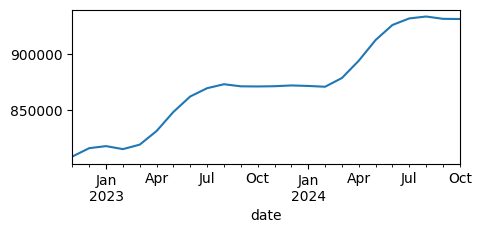

In [36]:
# Combine all of the three predictions into a final 'predicted value'
fcast_df['predicted_value'] = fcast_df['pred_trend'] + fcast_df['seasonal'] + fcast_df['residuals']

# Set the index using the previously stored residual index
fcast_df['date'] = fcast_index
fcast_df = fcast_df.set_index('date')

# Visualize the predicted values
fcast_df['predicted_value'].plot(figsize=(5,2))

### Visualize Predicted Values With Original Data

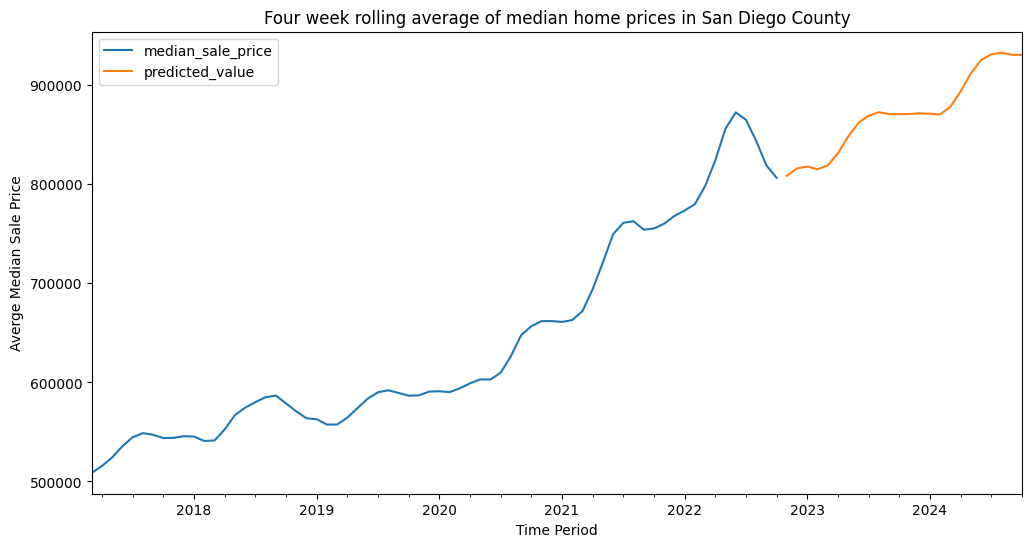

In [38]:
# Recreate and resample the original data to match the predicted data
df_plot = df_final.resample('MS').mean()


# Filter to remove duplicate values where original data and predictions overlap
df_plot = df_plot.iloc[:-6,:]


# Plot predictions against known values
title = 'Four week rolling average of median home prices in San Diego County'
ylabel='Averge Median Sale Price'
xlabel='Time Period'

ax = df_plot['median_sale_price'].plot(legend=True,figsize=(12,6),title=title)
fcast_df['predicted_value'].plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);